In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from superpoint.settings import EXPER_PATH
import superpoint.evaluations.detector_evaluation as ev
from utils import plot_imgs
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
experiments = ['magic-point_coco_repeatability', 'harris_coco_repeatability', 'shi_coco_repeatability', 'fast_coco_repeatability']
confidence_thresholds = [0.015, 90000, 0.06, 40]

# Patches visualization

In [12]:
def draw_keypoints(img, corners, color, s = 3):
    keypoints = [cv2.KeyPoint(c[1]*s, c[0]*s, 1) for c in np.stack(corners).T]
    img = cv2.resize(img, None, fx=s, fy=s)
    return cv2.drawKeypoints(img.astype(np.uint8), keypoints, None, color=color)

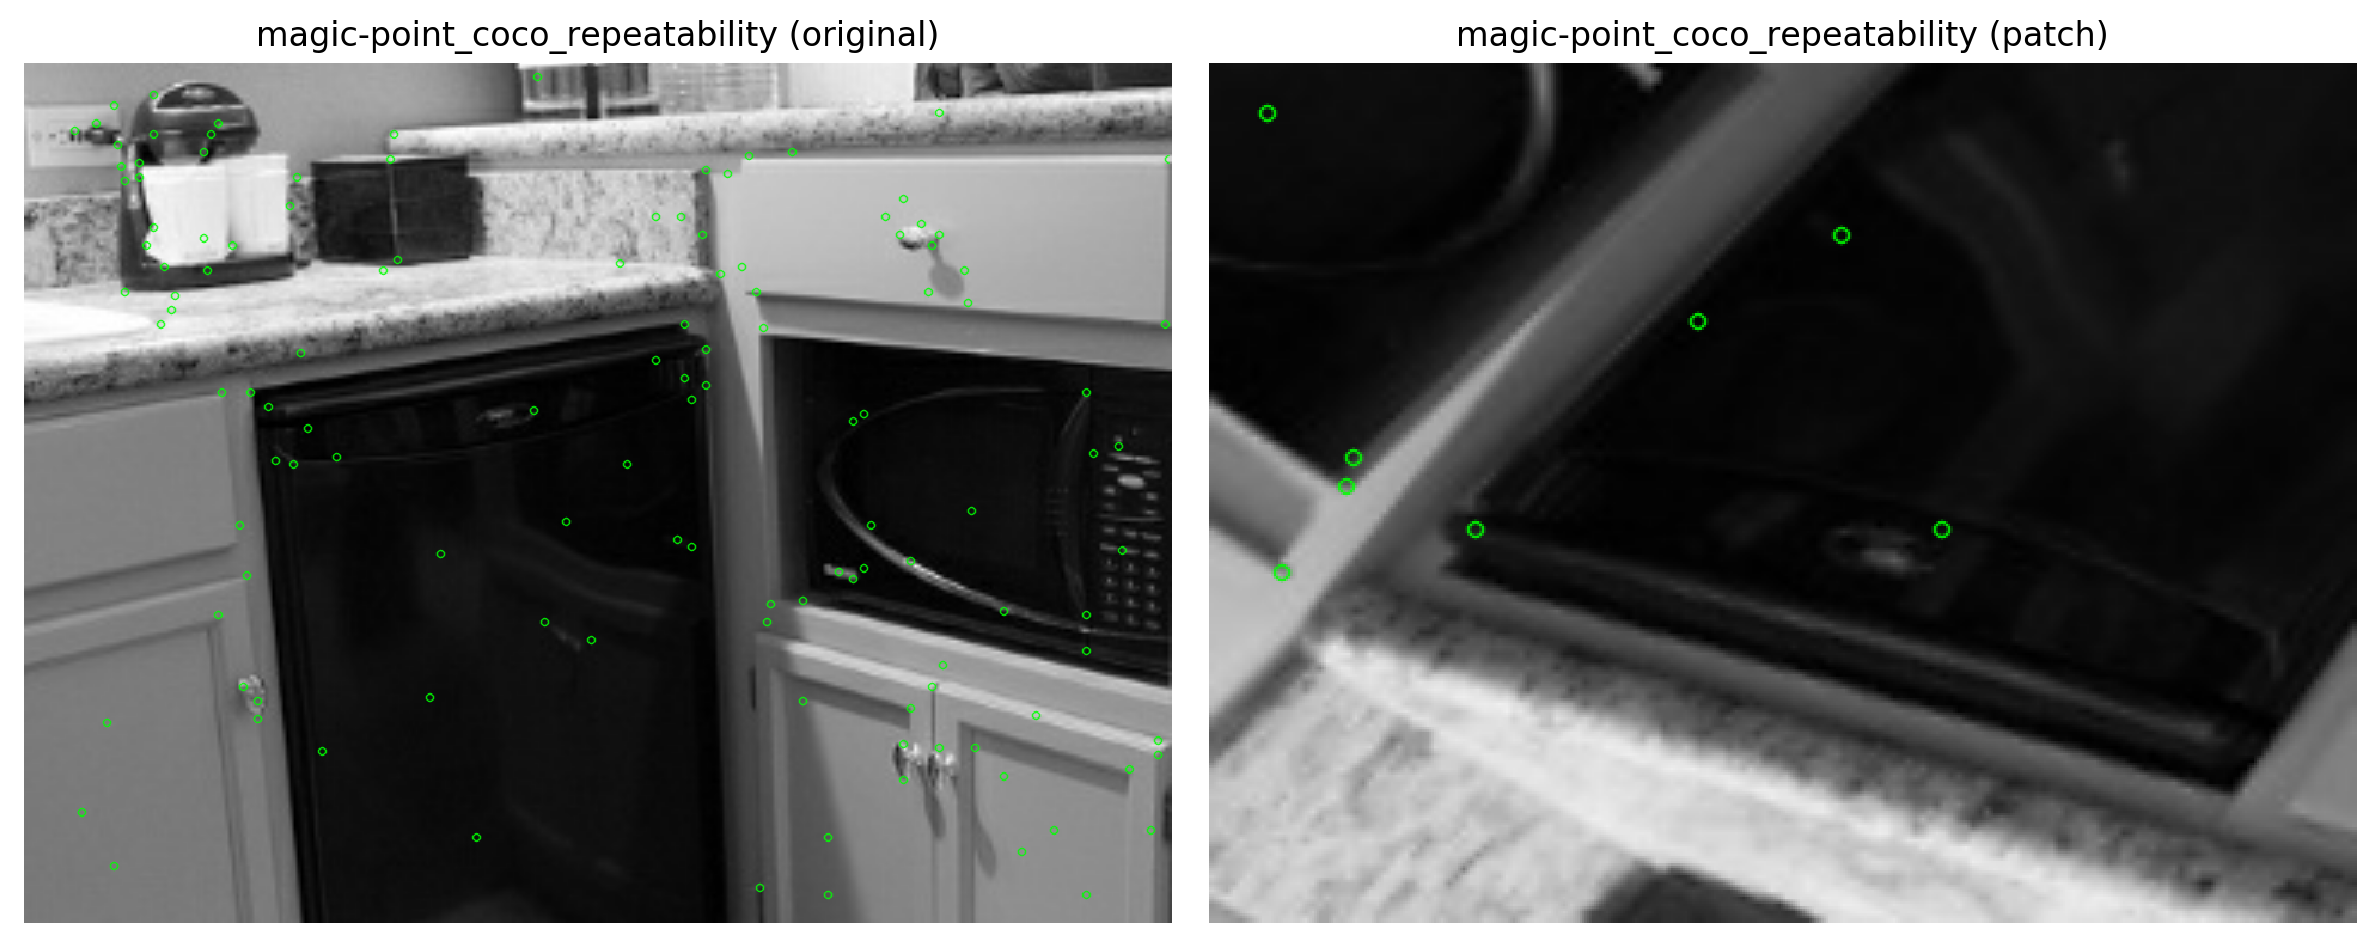

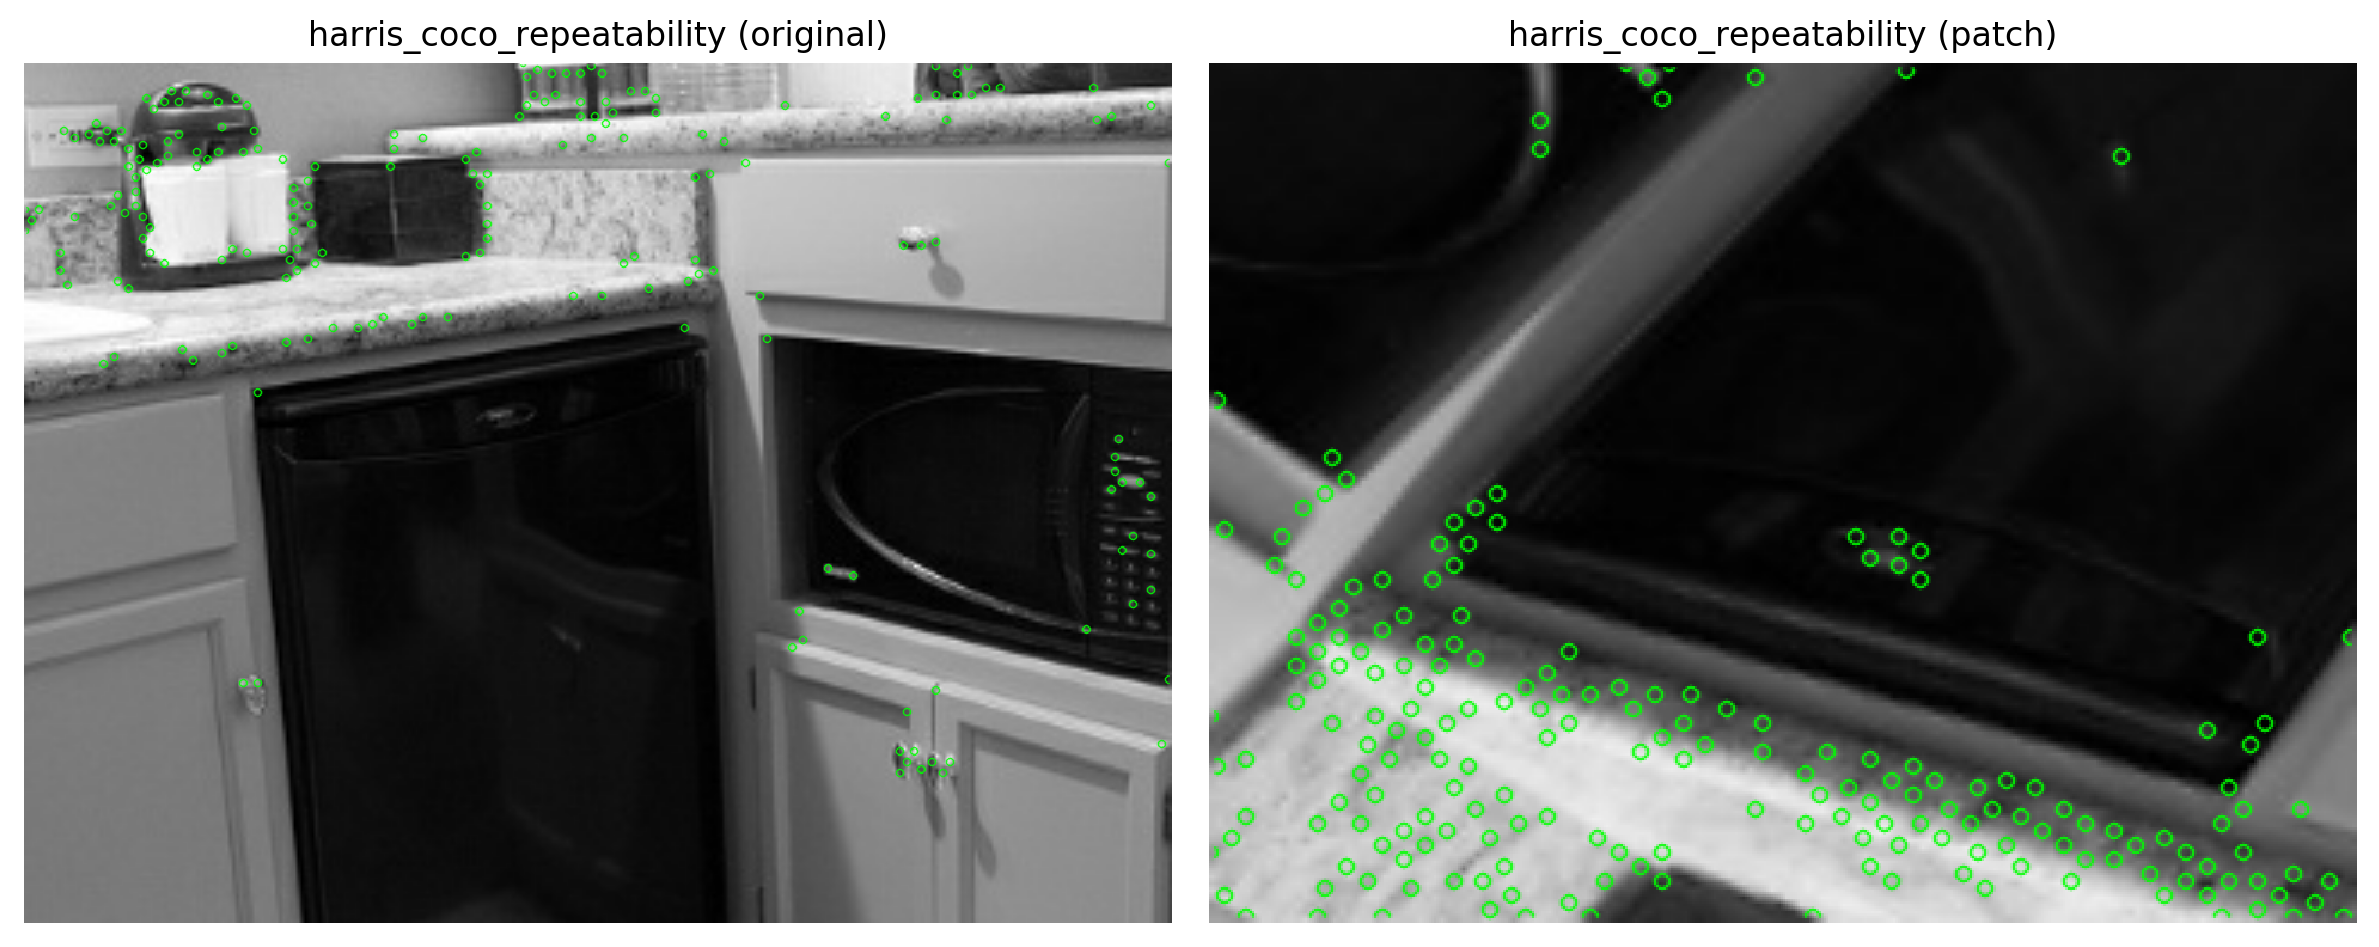

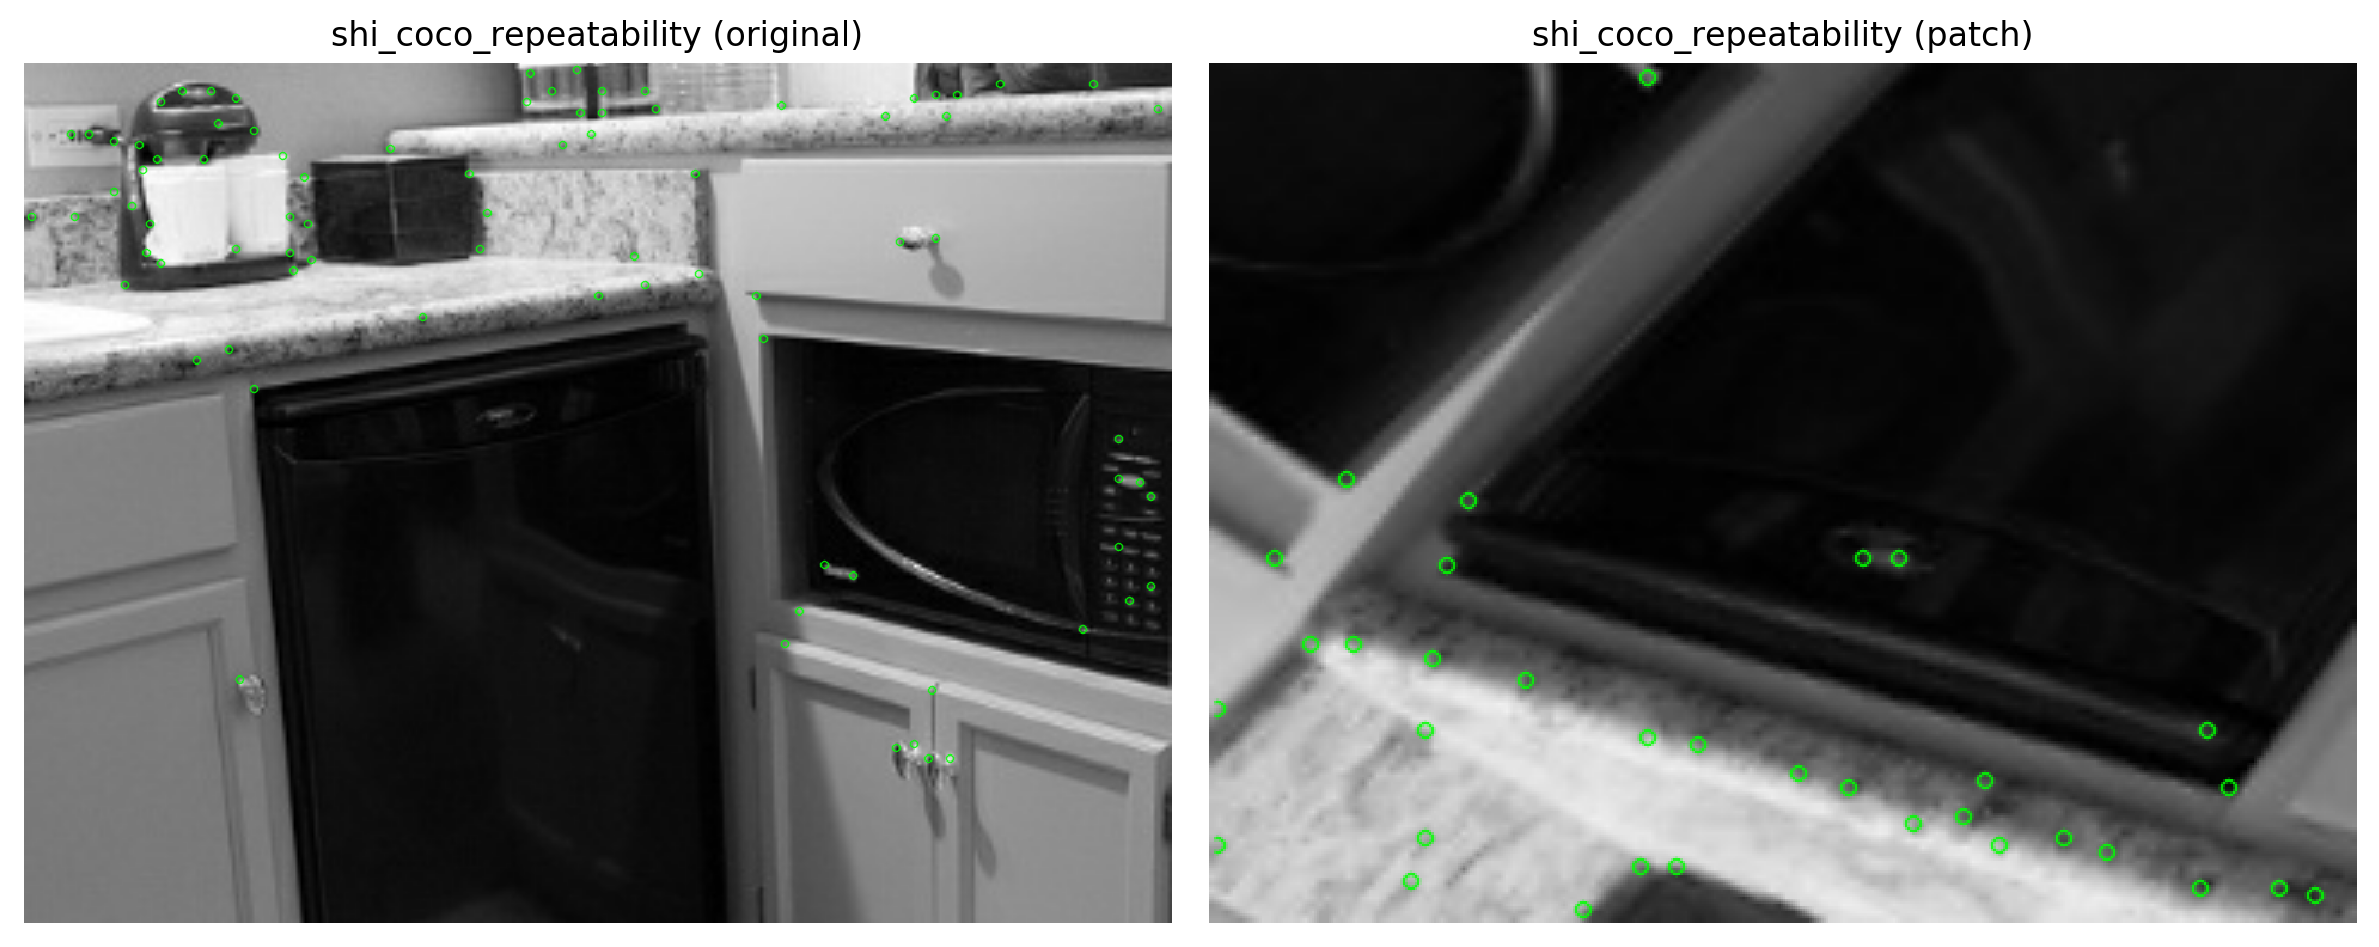

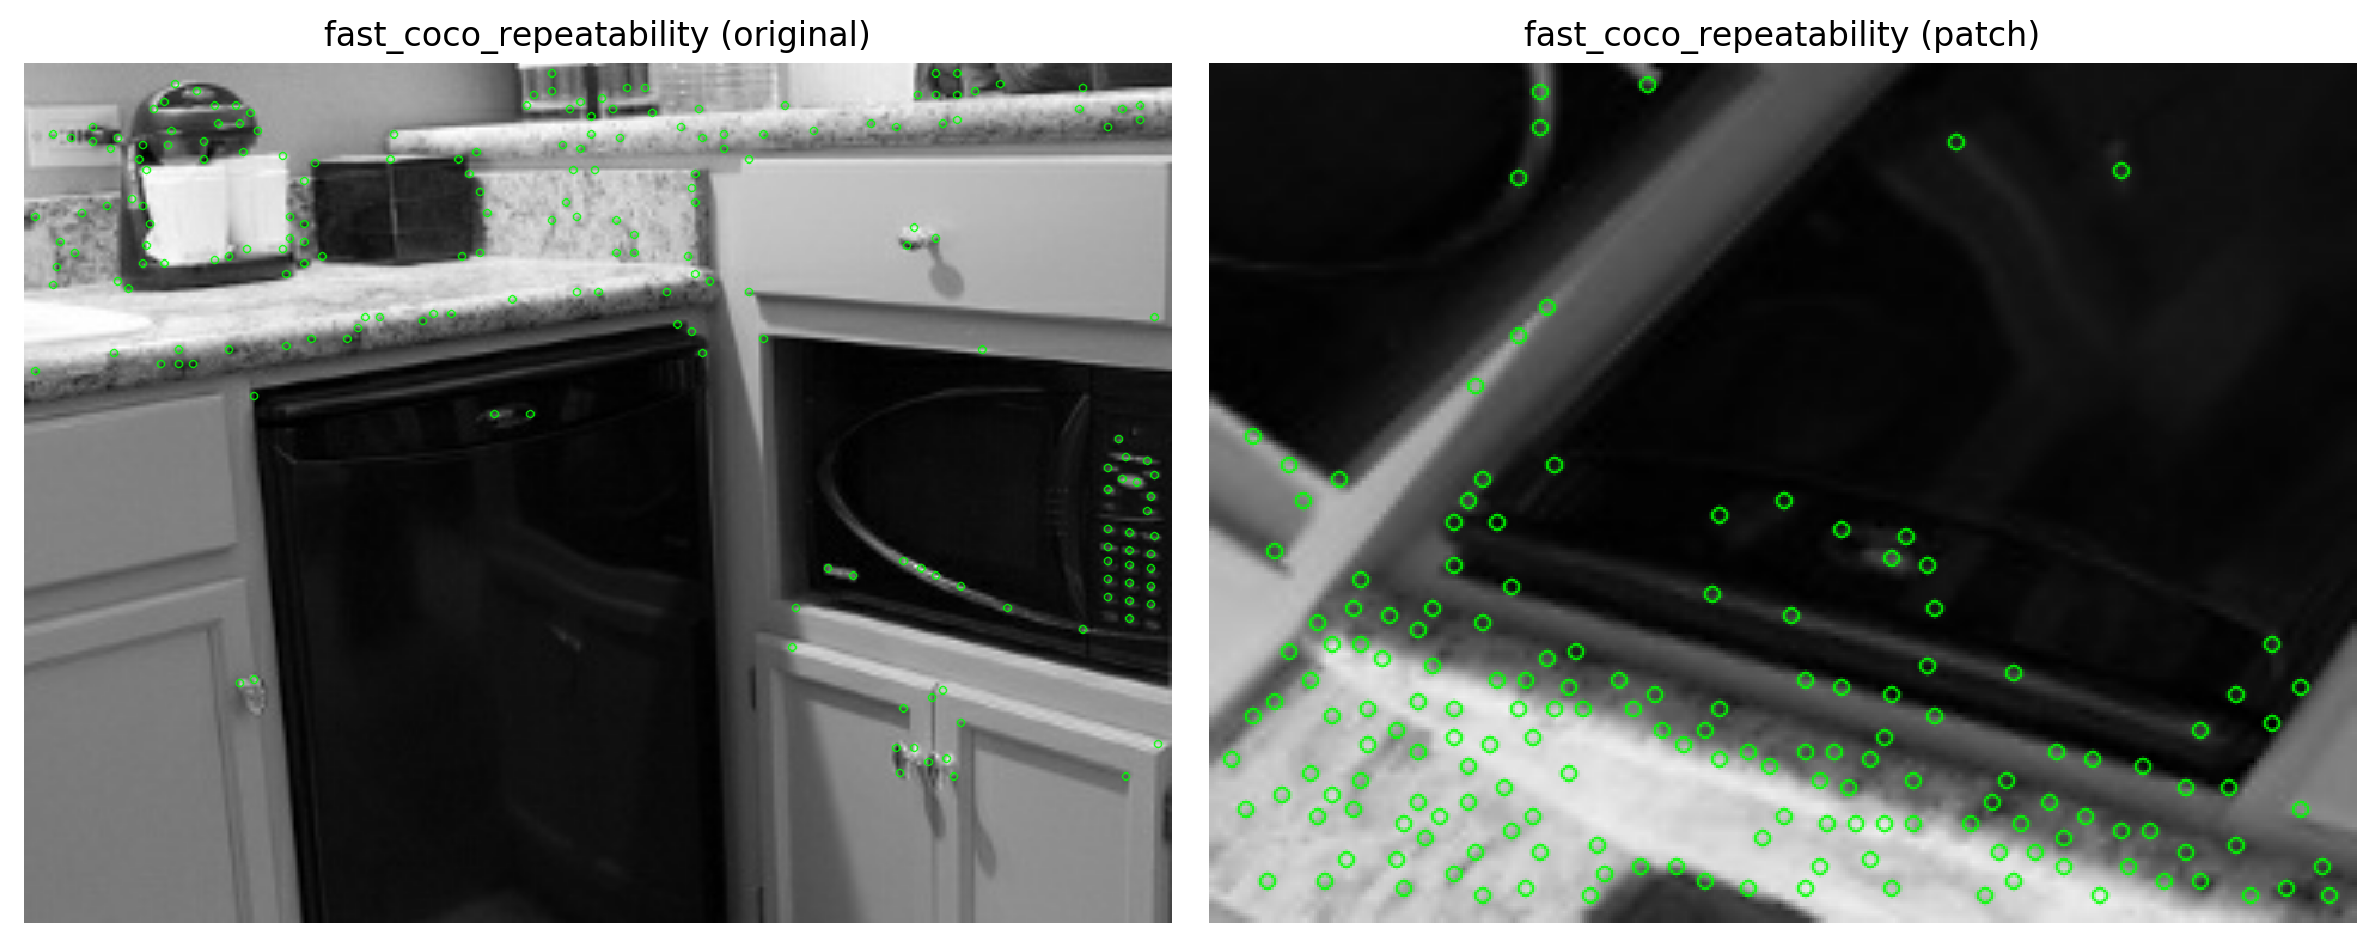

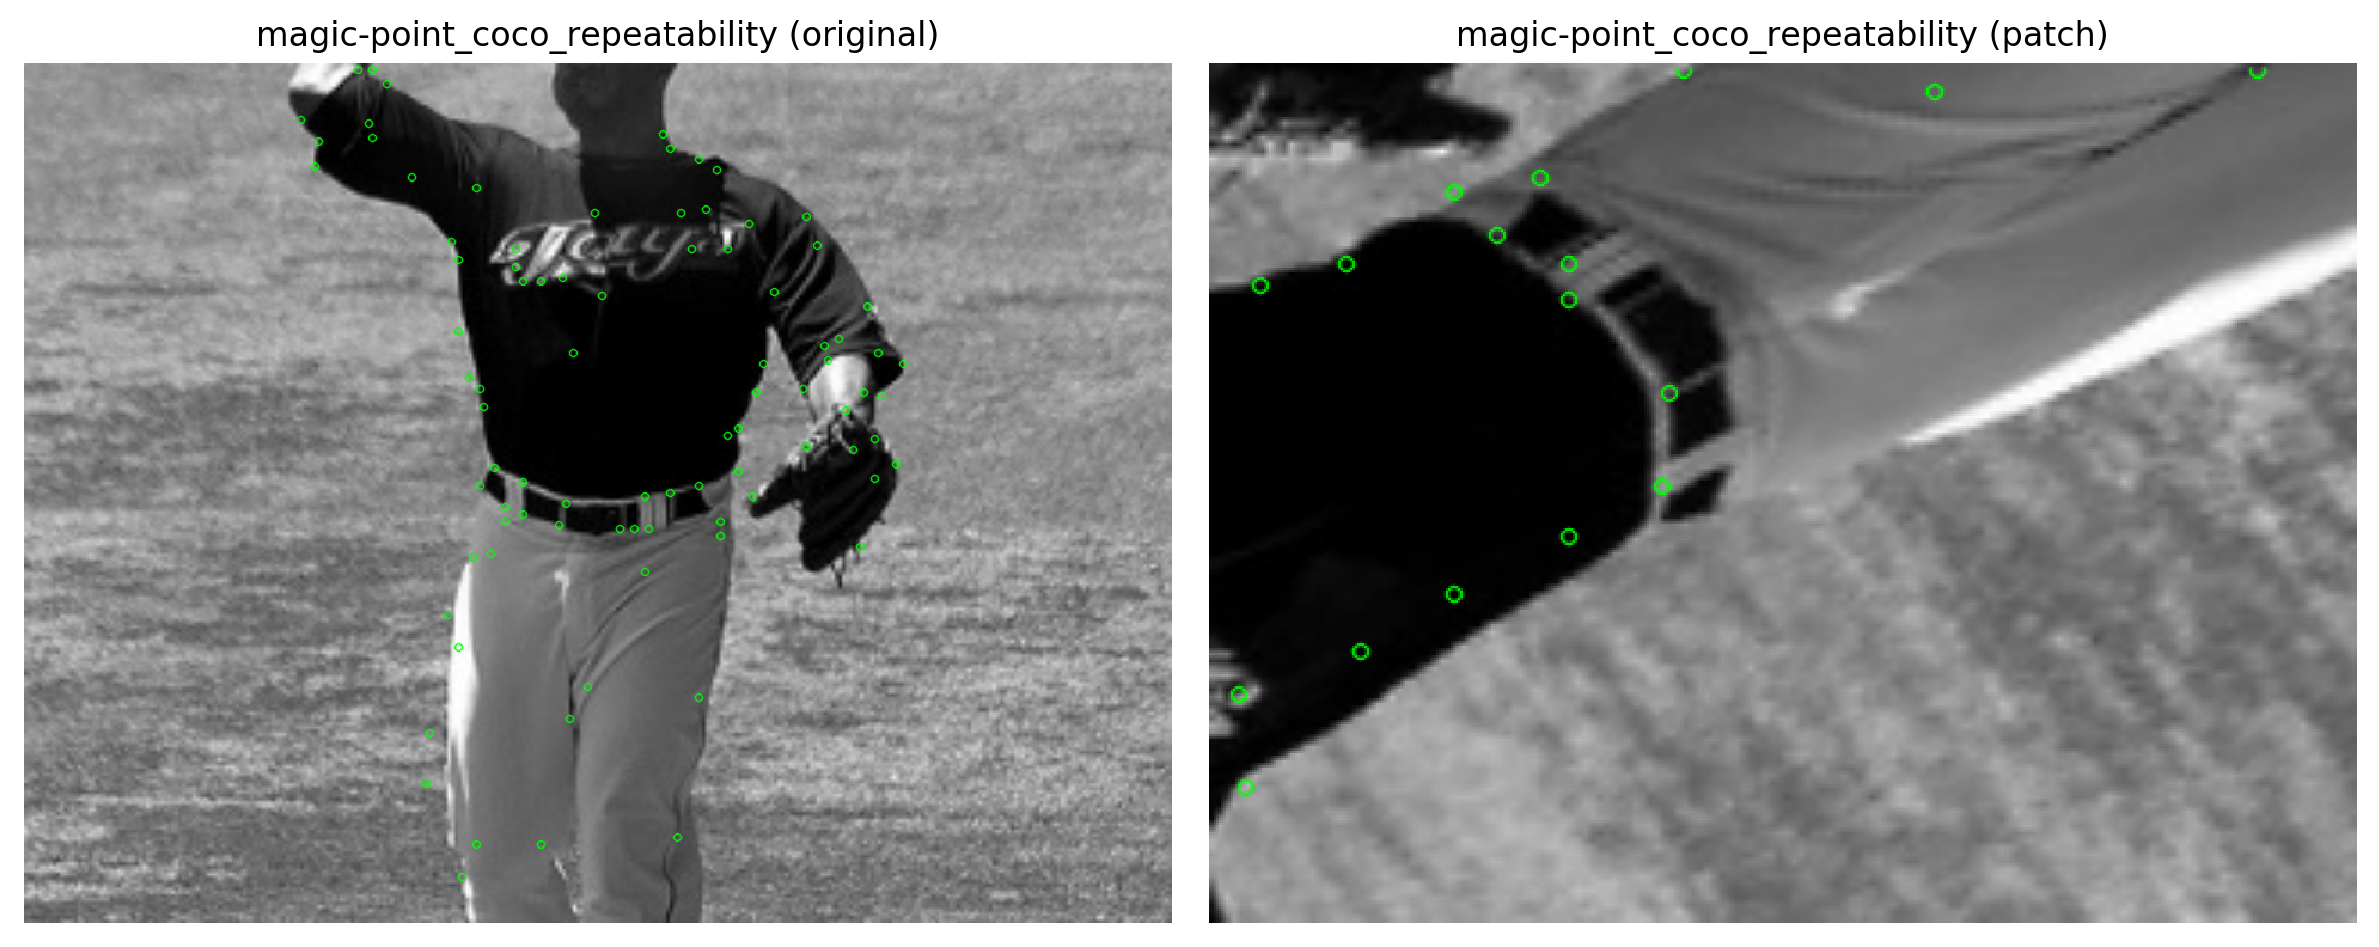

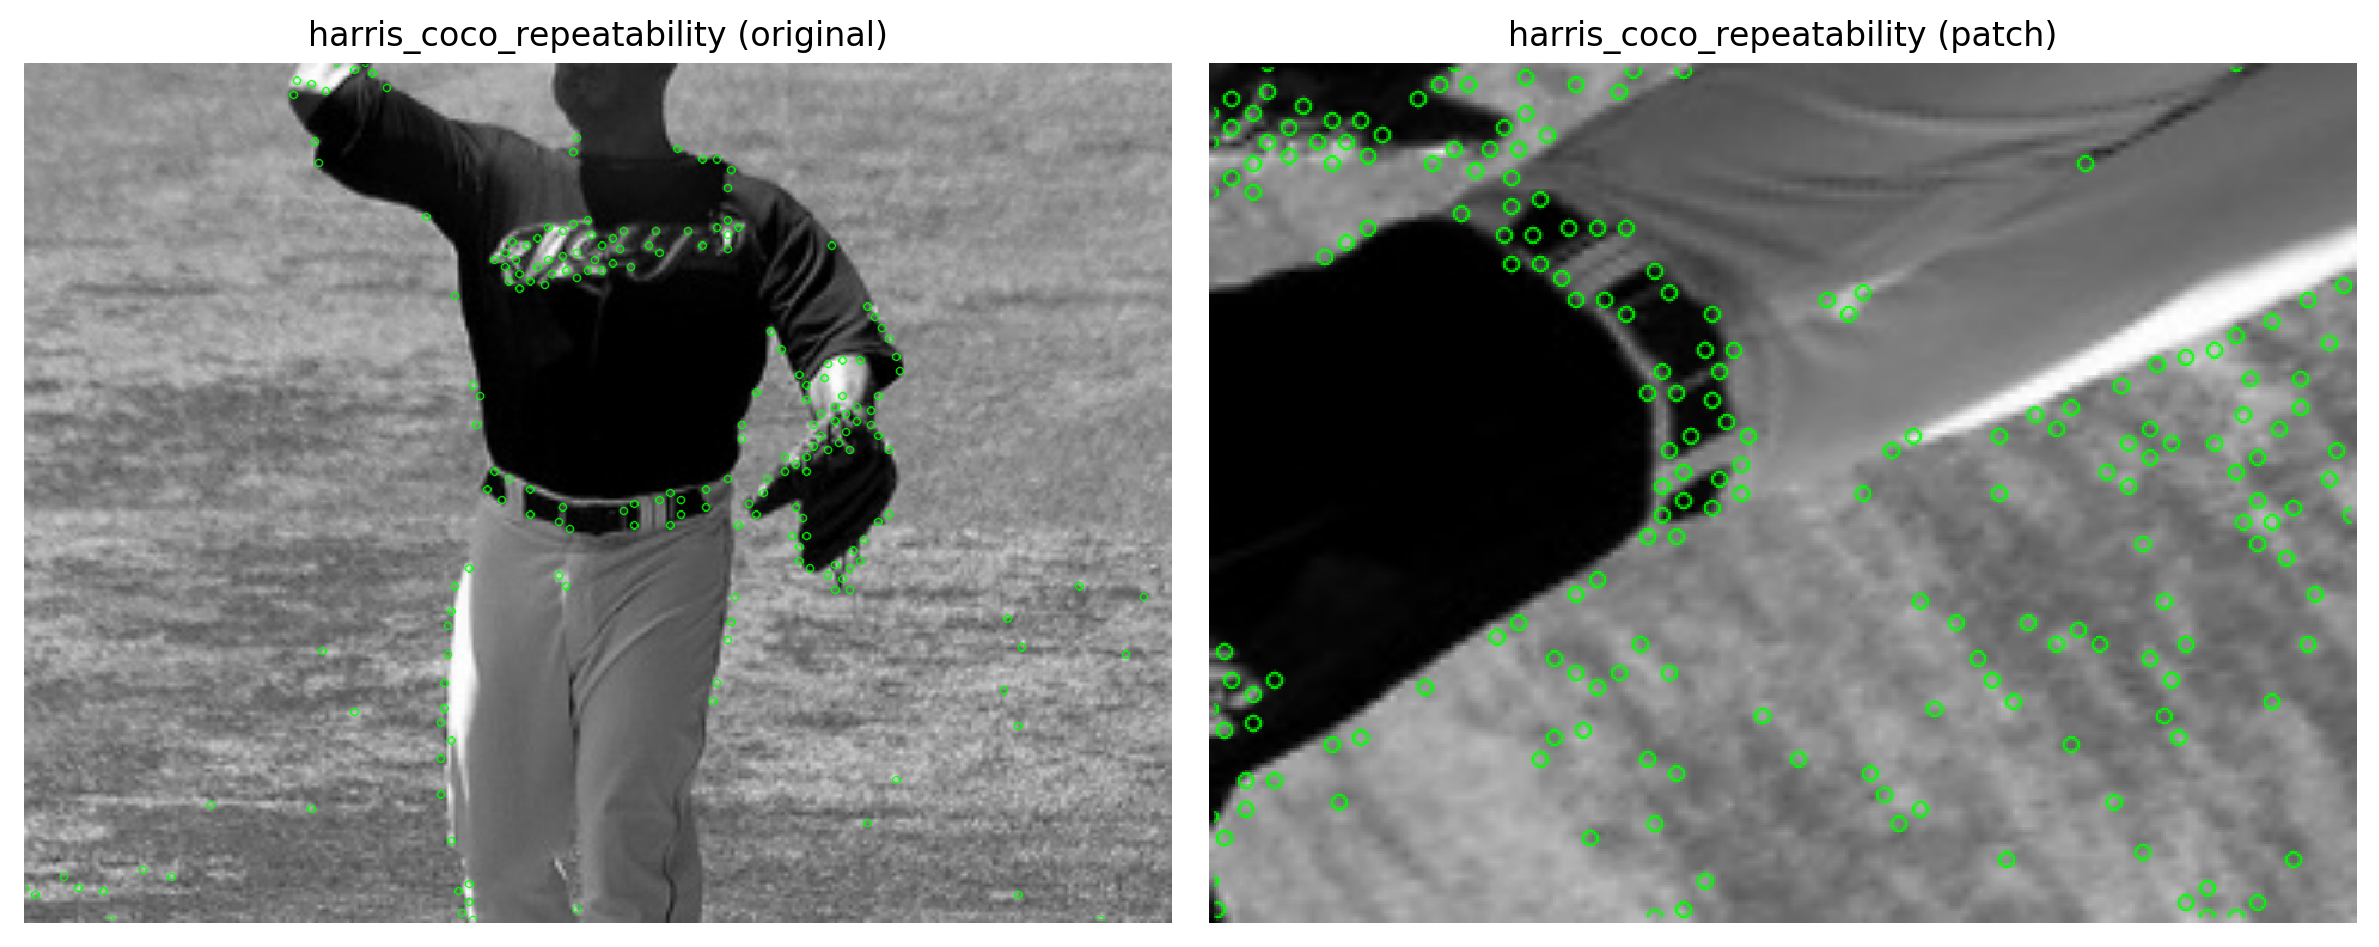

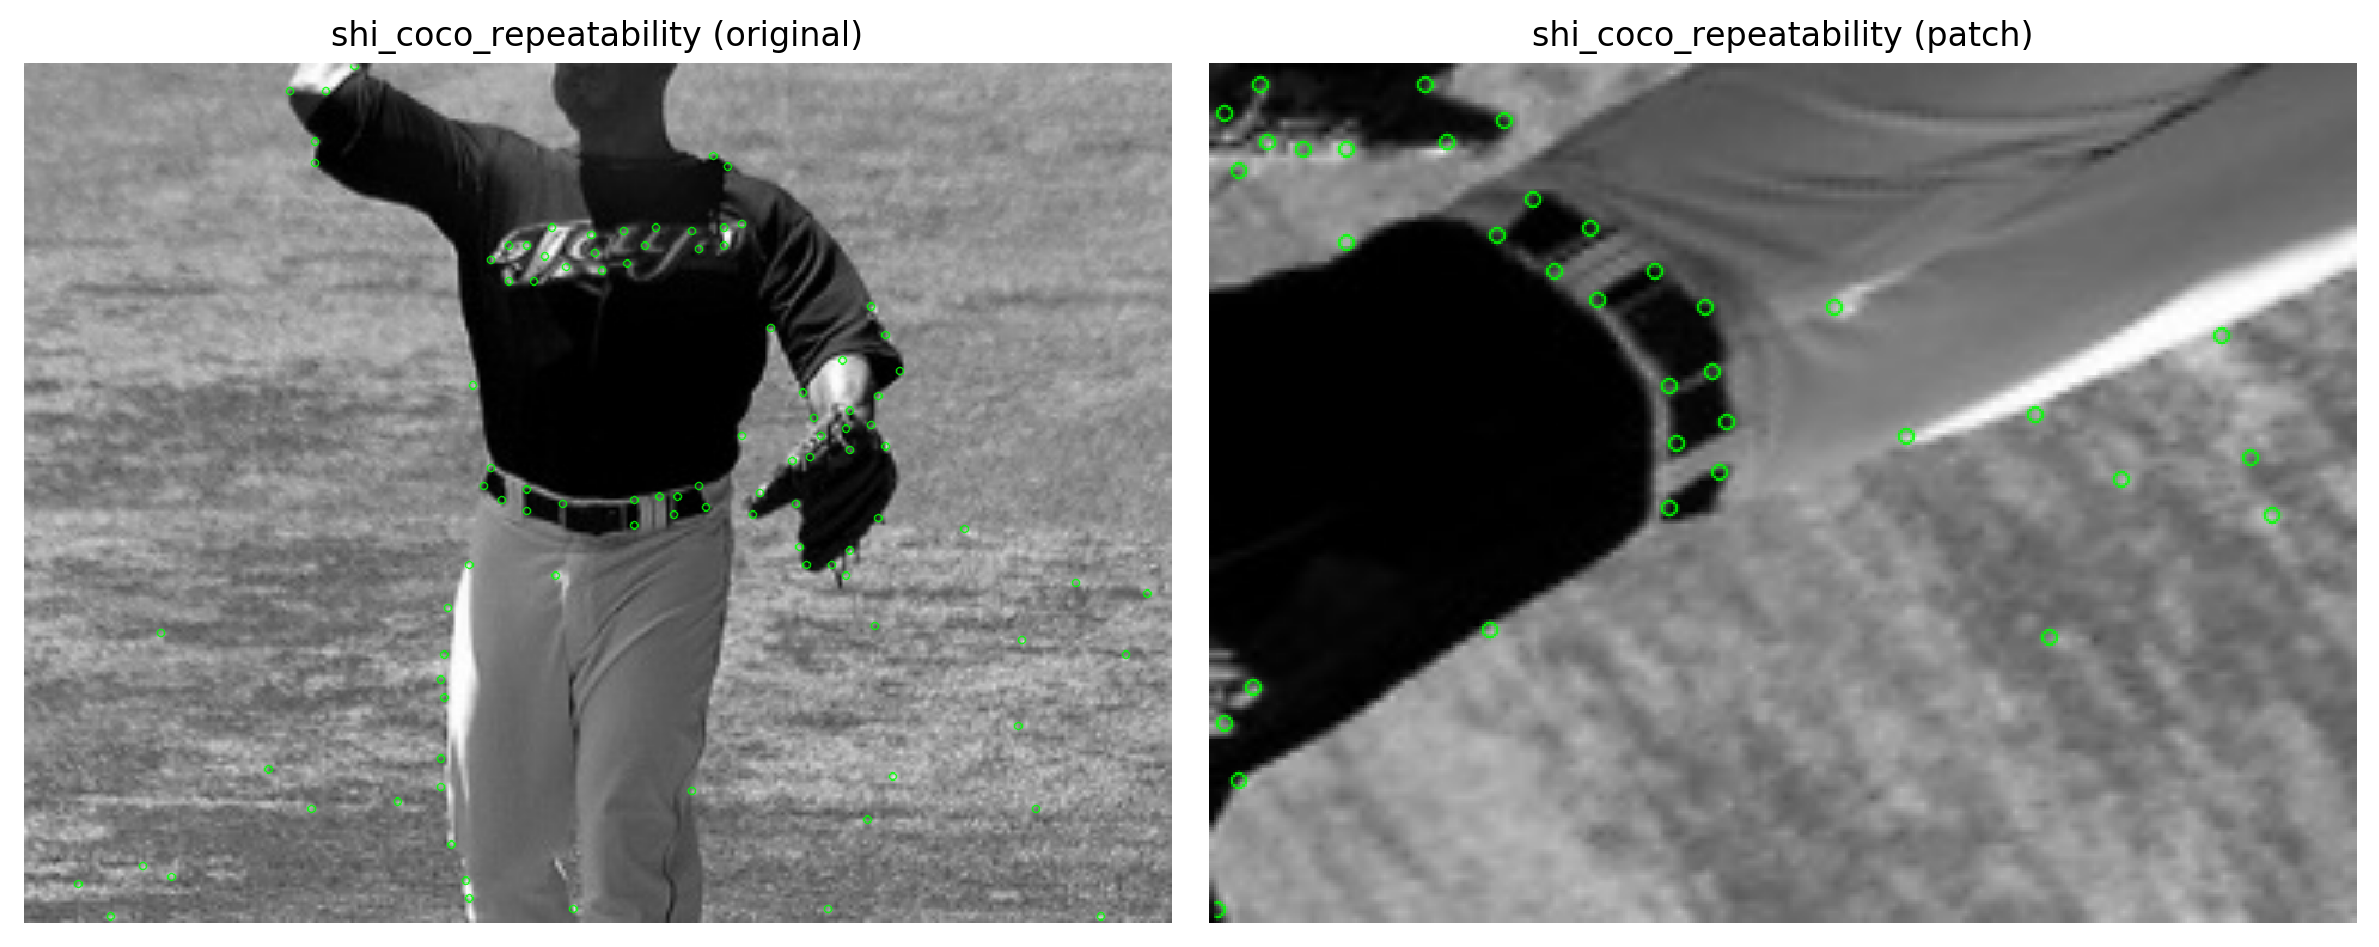

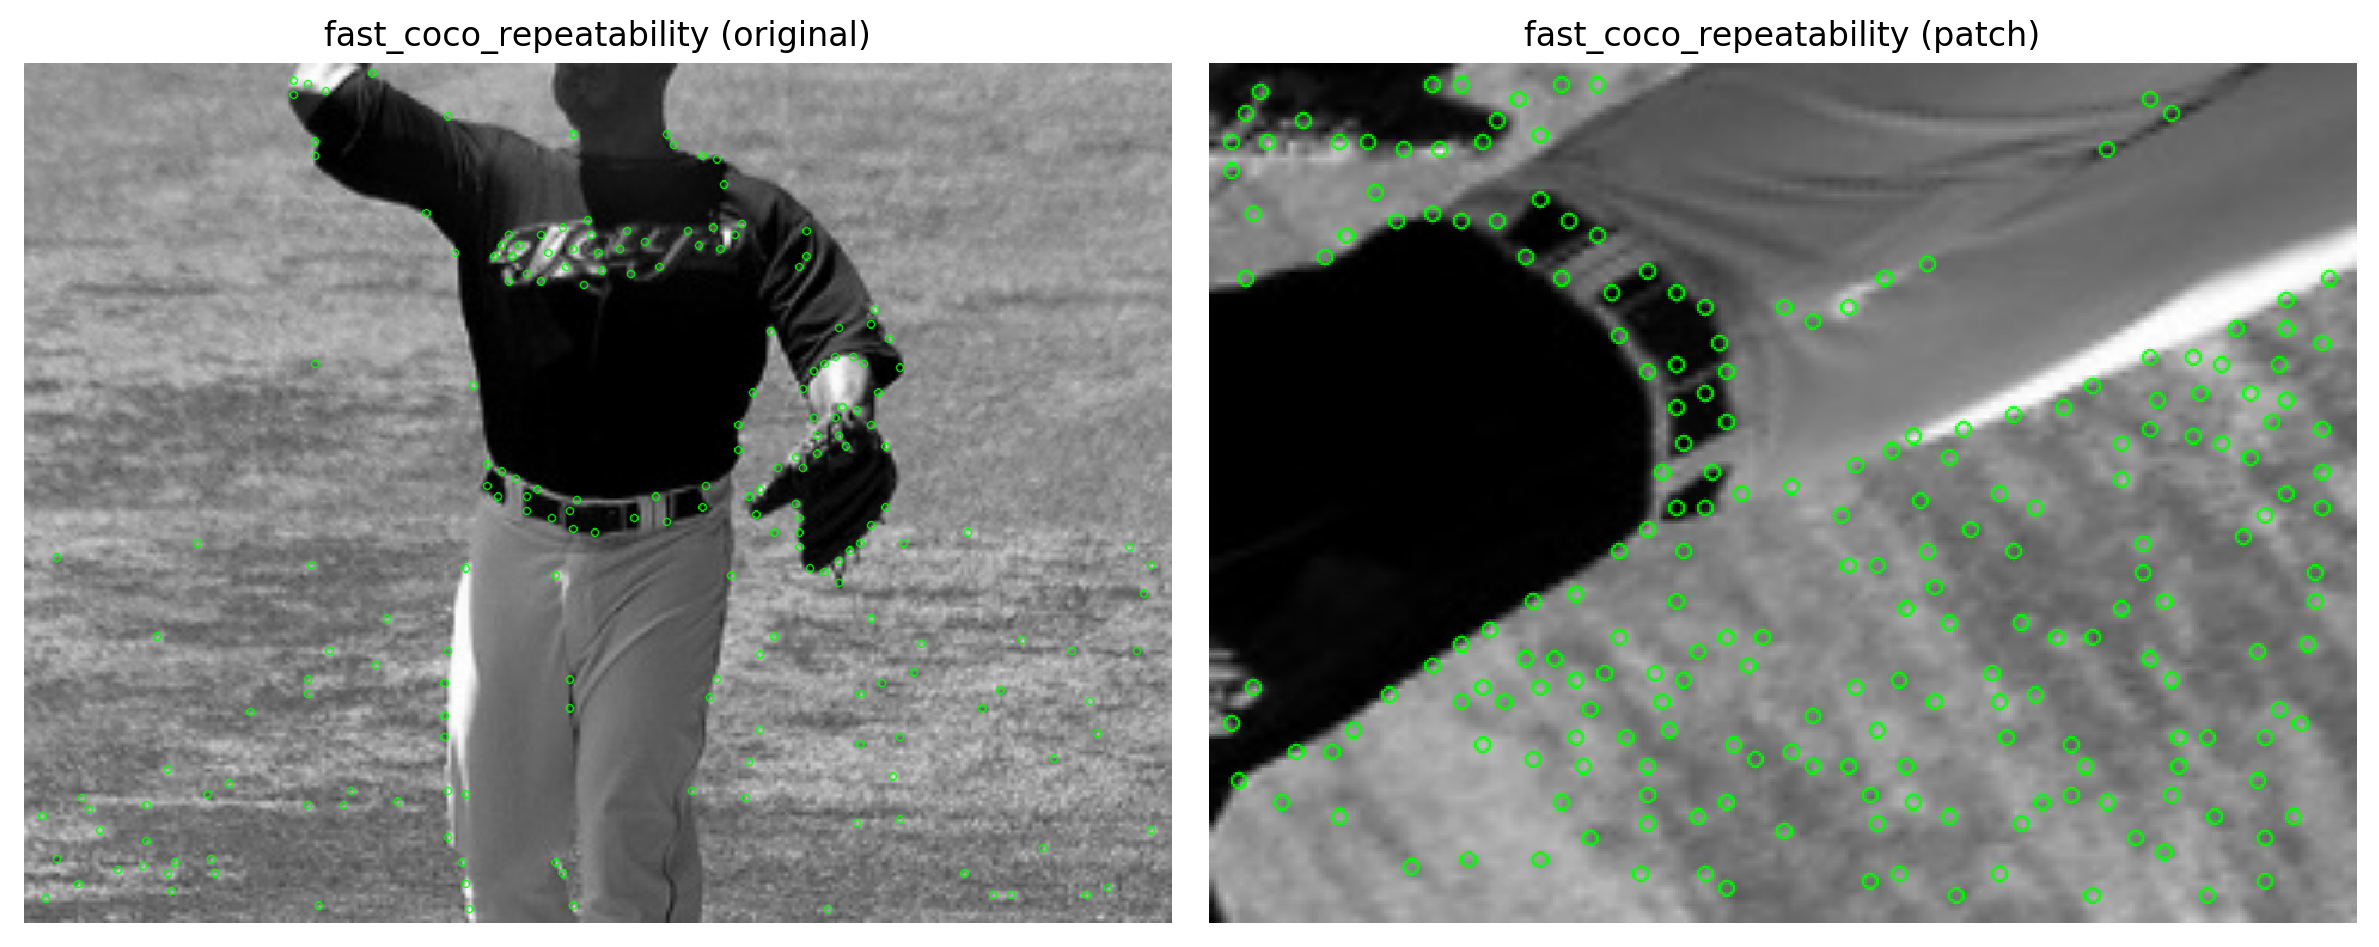

In [13]:
for i in range(2):
    for e, thresh in zip(experiments, confidence_thresholds):
        path = Path(EXPER_PATH, "outputs", e, str(i) + ".npz")
        d = np.load(path)
        
        #points1 = np.where(d['prob'] > thresh)
        points1 = ev.select_k_points(d['prob'], k=200)
        im1 = draw_keypoints(d['image'][..., 0], points1, (0, 255, 0)) / 255.
        
        #points2 = np.where(d['warped_prob'] > thresh)
        points2 = ev.select_k_points(d['warped_prob'], k=200)
        im2 = draw_keypoints(d['warped_image'], points2, (0, 255, 0)) / 255.
        
        plot_imgs([im1, im2], titles=[e + ' (original)', e + ' (patch)'], dpi=200, cmap='gray')

# Repeatability

In [14]:
for exp, thresh in zip(experiments, confidence_thresholds):
    repeatability = ev.compute_repeatability(exp, prob_thresh=thresh, distance_thresh=3)
    print('> {}: {}'.format(exp, repeatability))

> magic-point_coco_repeatability: 0.23365442596726216
> harris_coco_repeatability: 0.6662249318046467
> shi_coco_repeatability: 0.49842945232580466
> fast_coco_repeatability: 0.6565472908599461


# Visual proof that the true keypoints are warped as expected

In [15]:
def get_true_keypoints(exper_name, prob_thresh=0.5):
    def warp_keypoints(keypoints, H):
        warped_col0 = np.add(np.sum(np.multiply(keypoints, H[0, :2]), axis=1), H[0, 2])
        warped_col1 = np.add(np.sum(np.multiply(keypoints, H[1, :2]), axis=1), H[1, 2])
        warped_col2 = np.add(np.sum(np.multiply(keypoints, H[2, :2]), axis=1), H[2, 2])
        warped_col0 = np.divide(warped_col0, warped_col2)
        warped_col1 = np.divide(warped_col1, warped_col2)
        new_keypoints = np.concatenate([warped_col0[:, None], warped_col1[:, None]],
                                       axis=1)
        return new_keypoints

    def filter_keypoints(points, shape):
        """ Keep only the points whose coordinates are
        inside the dimensions of shape. """
        mask = (points[:, 0] >= 0) & (points[:, 0] < shape[0]) &\
               (points[:, 1] >= 0) & (points[:, 1] < shape[1])
        return points[mask, :]
    
    true_keypoints = []
    for i in range(5):
        path = Path(EXPER_PATH, "outputs", exper_name, str(i) + ".npz")
        data = np.load(path)
        shape = data['warped_prob'].shape

        # Filter out predictions
        keypoints = np.where(data['prob'] > prob_thresh)
        keypoints = np.stack([keypoints[0], keypoints[1]], axis=-1)
        warped_keypoints = np.where(data['warped_prob'] > prob_thresh)
        warped_keypoints = np.stack([warped_keypoints[0], warped_keypoints[1]], axis=-1)

        # Warp the original keypoints with the true homography
        H = data['homography']
        true_warped_keypoints = warp_keypoints(keypoints[:, [1, 0]], H)
        true_warped_keypoints[:, [0, 1]] = true_warped_keypoints[:, [1, 0]]
        true_warped_keypoints = filter_keypoints(true_warped_keypoints, shape)
        true_keypoints.append((true_warped_keypoints[:, 0], true_warped_keypoints[:, 1]))
        
    return true_keypoints

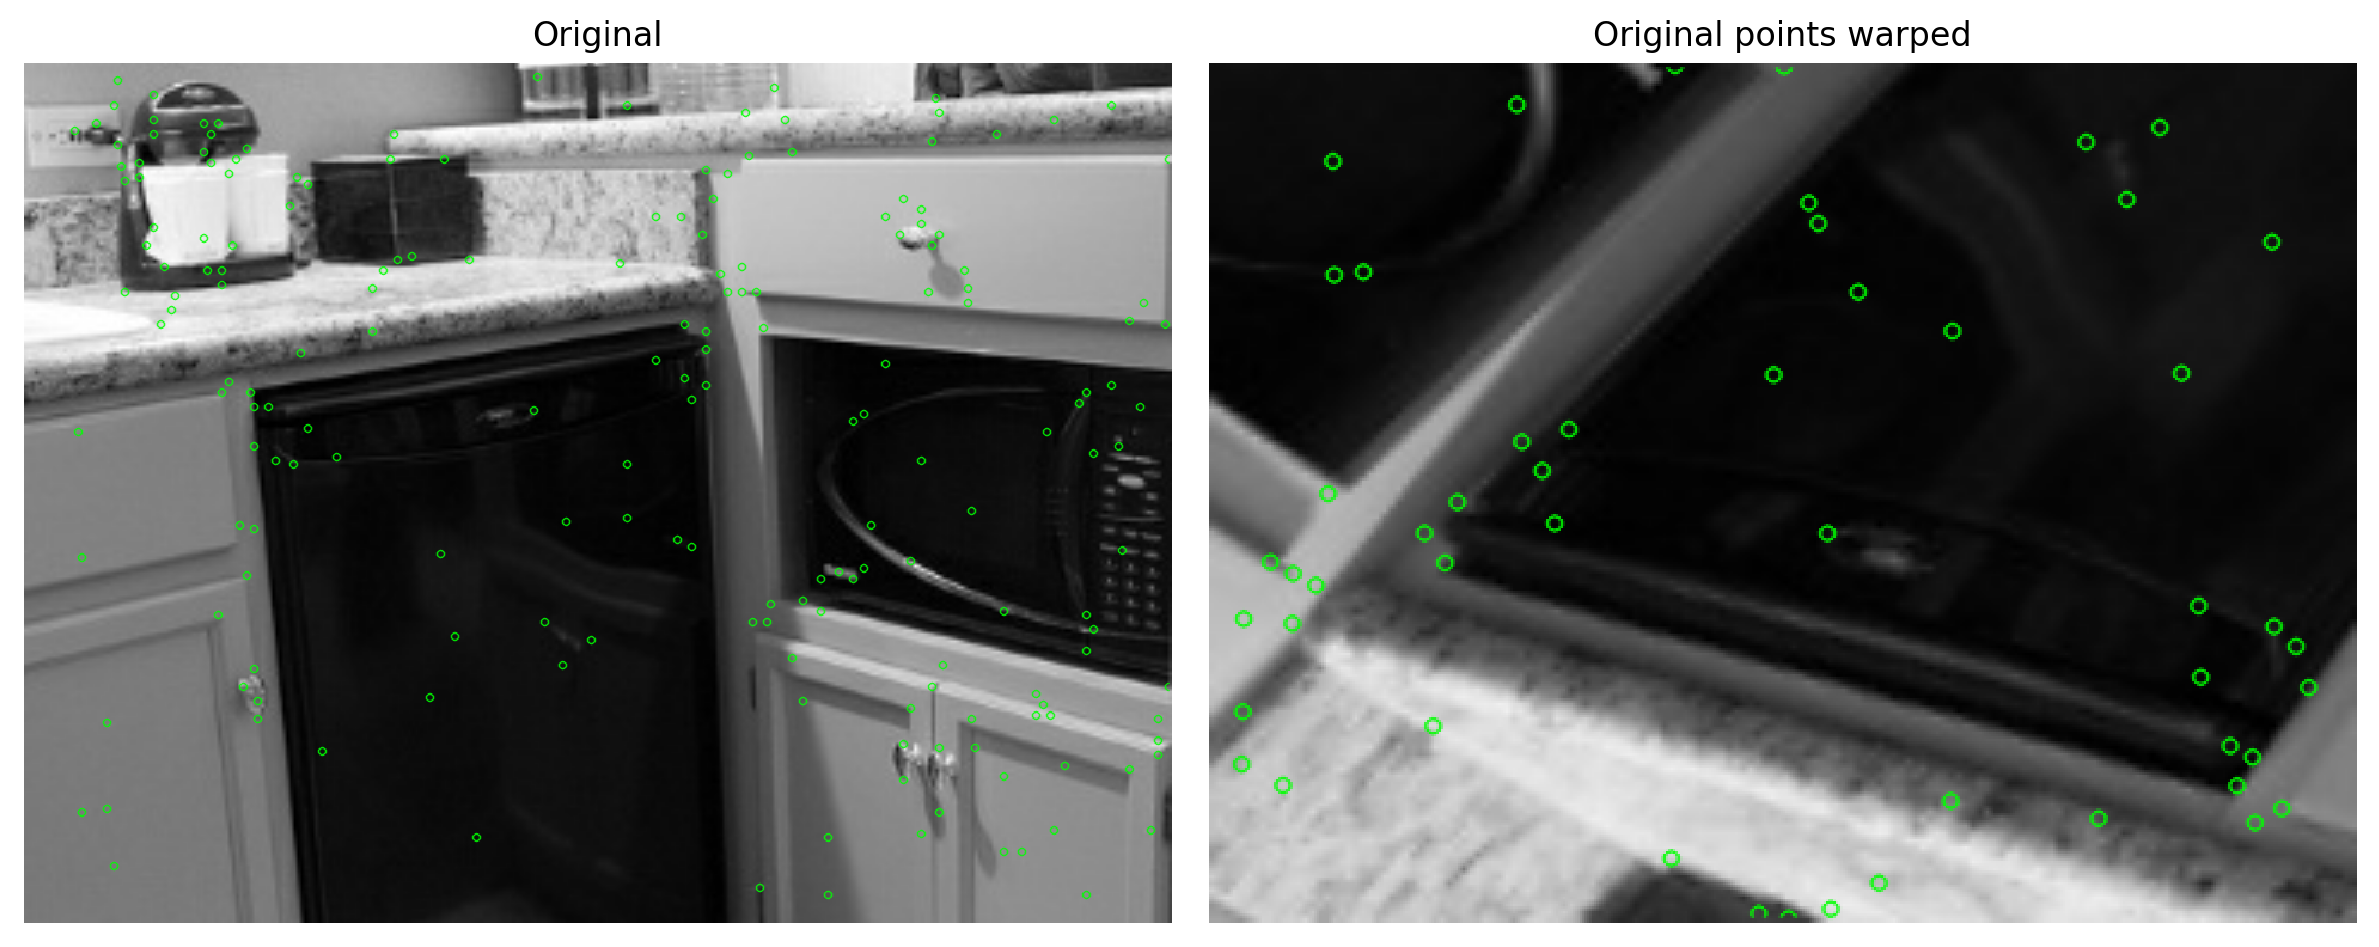

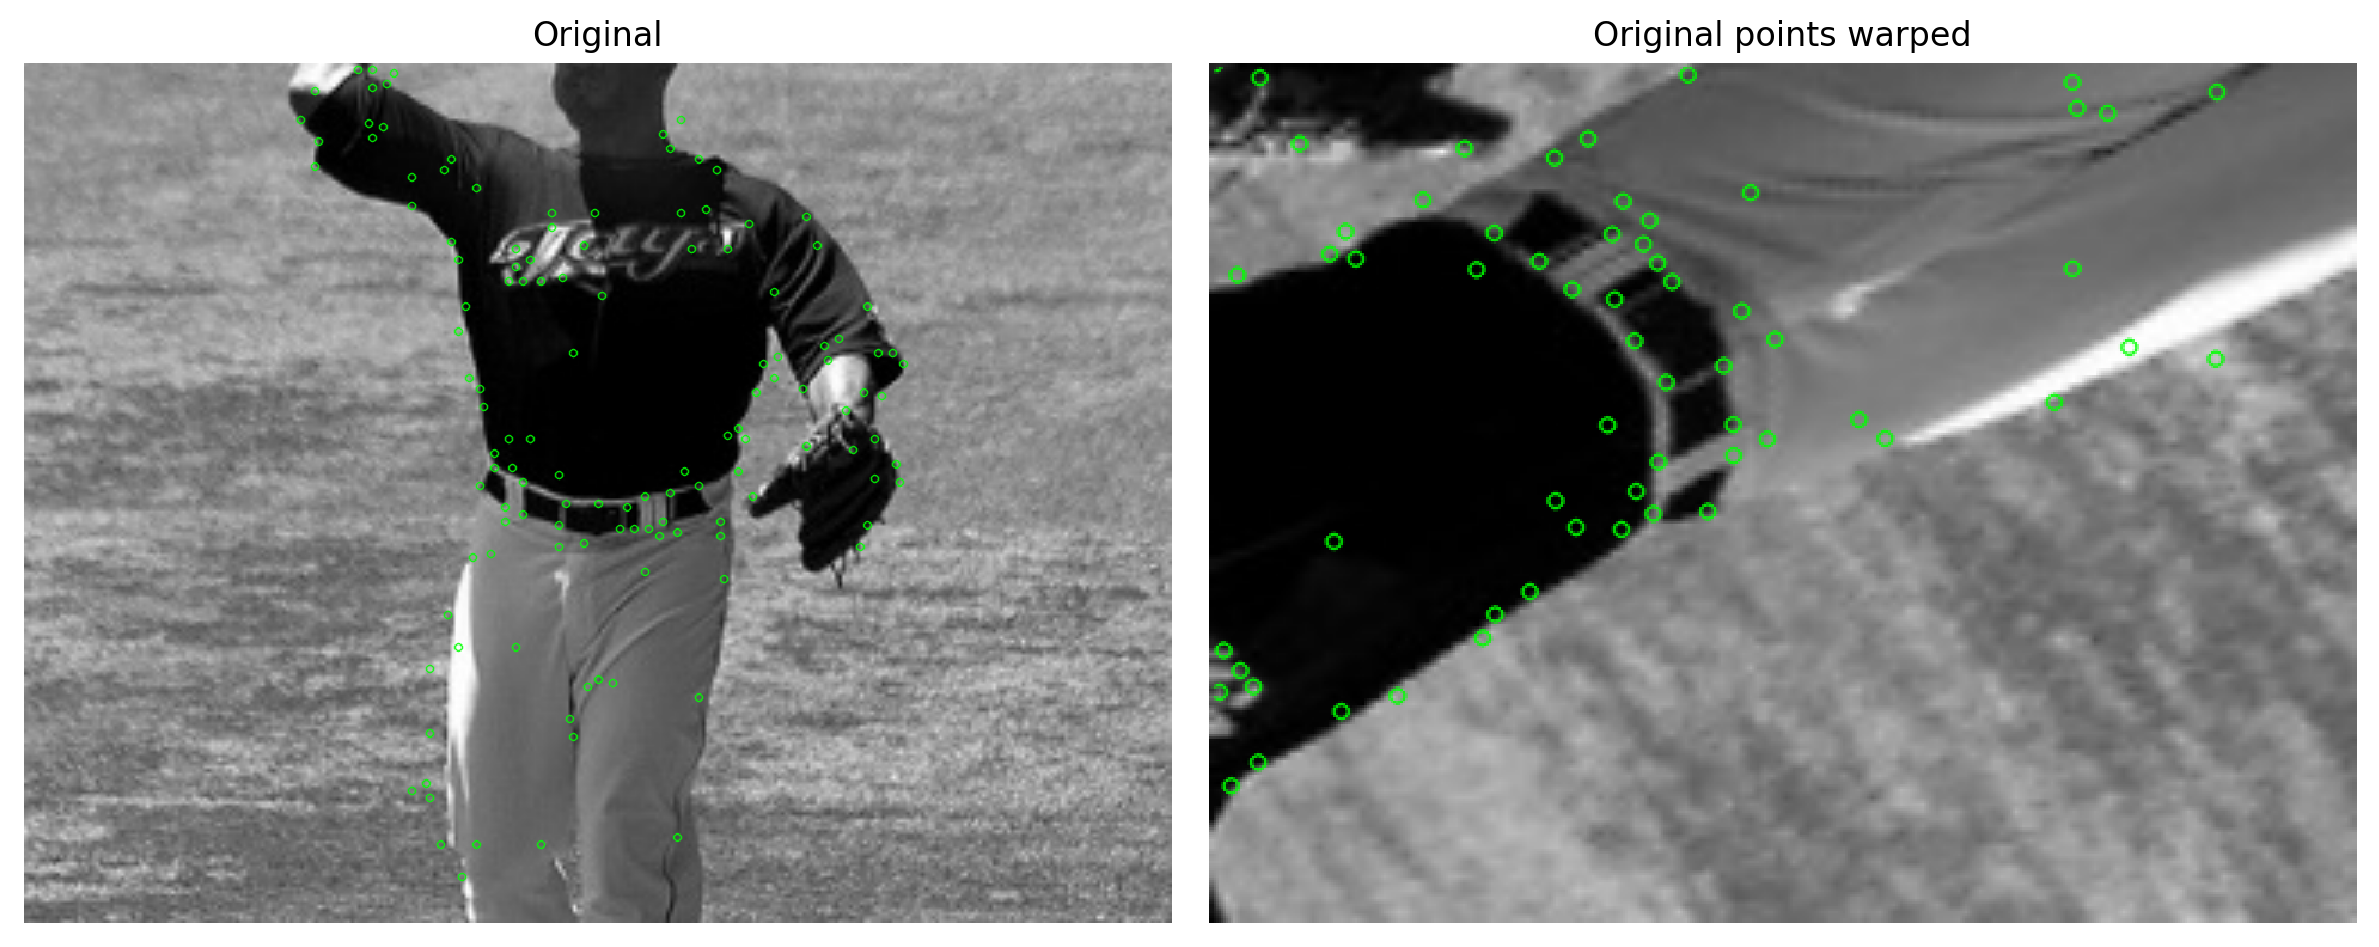

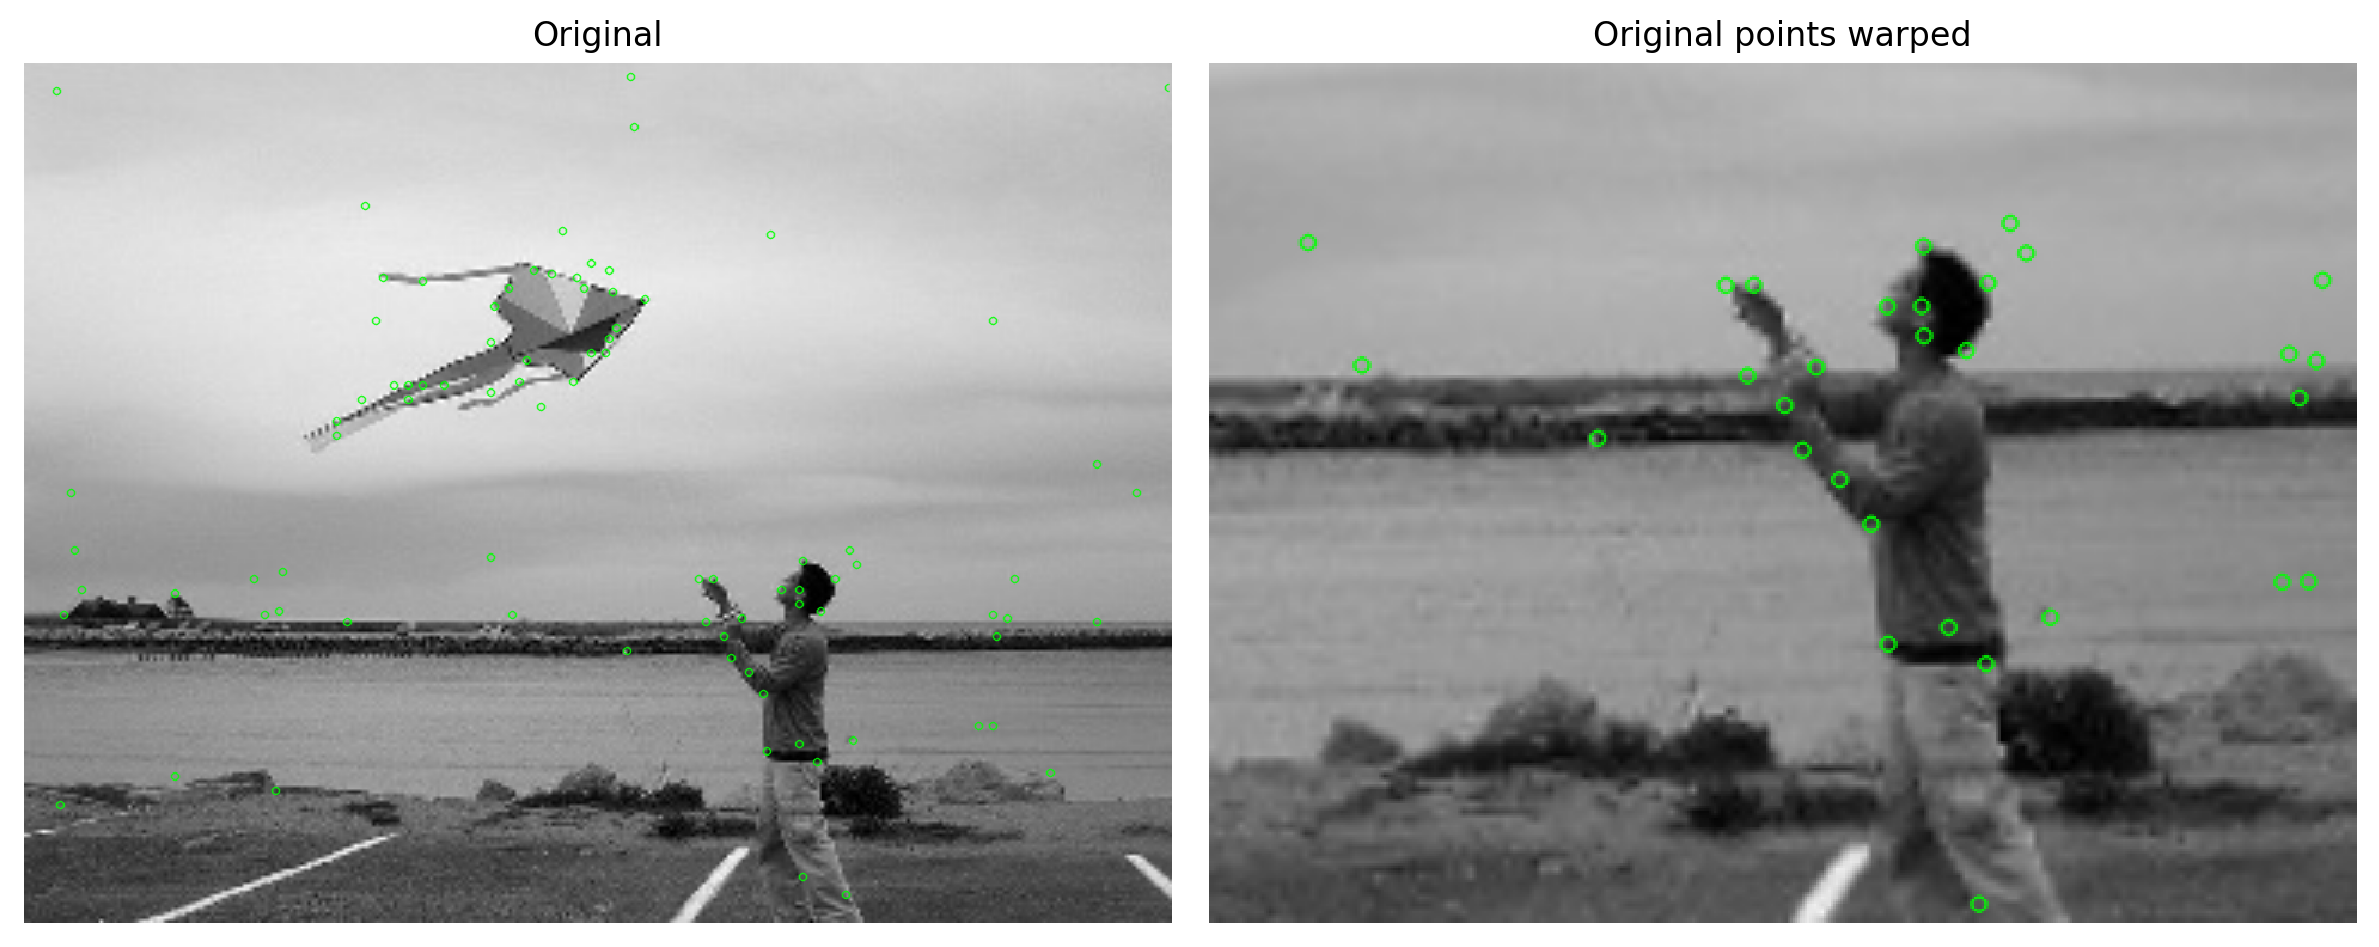

In [16]:
true_keypoints = get_true_keypoints('magic-point_coco_repeatability', 0.015)
for i in range(3):
    e = 'magic-point_coco_repeatability'
    thresh = 0.015
    path = Path(EXPER_PATH, "outputs", e, str(i) + ".npz")
    d = np.load(path)
        
    points1 = np.where(d['prob'] > thresh)
    im1 = draw_keypoints(d['image'][..., 0], points1, (0, 255, 0)) / 255.
        
    points2 = true_keypoints[i]
    im2 = draw_keypoints(d['warped_image'][..., 0], points2, (0, 255, 0)) / 255.
        
    plot_imgs([im1, im2], titles=['Original', 'Original points warped'], dpi=200, cmap='gray')